In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/RAGwithLangChain.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


data/RAGwithLangChain.pdf


In [28]:
from langchain_openai import ChatOpenAI
from rag.utils import format_docs
from langgraph.graph.state import CompiledStateGraph
from langchain_core.runnables import RunnableConfig
from typing import Any, Dict, List, Callable, Optional
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate

def get_role_from_messages(msg):
    if isinstance(msg, HumanMessage):
        return "user"
    elif isinstance(msg, AIMessage):
        return "assistant"
    else:
        return "assistant"

def messages_to_history(messages):
    result =  "\n".join(
        [f"{get_role_from_messages(msg)}: {msg.content}" for msg in messages]
    )
    return result

class GroundnessQuestionScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the answer is relevant to the question else answer 'no'"
    )

class GroundnessAnswerRetrievalScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the answer is relevant to the retrieved document else answer 'no'"
    )

class GroundnessQuestionRetrievalScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the question is relevant to the retrieved document else answer 'no'"
    )

class GroundednessChecker:
    """
    GroundednessChecker 클래스는 문서의 정확성을 평가하는 클래스입니다.

    이 클래스는 주어진 문서가 정확한지 여부를 평가합니다.
    'yes' 또는 'no' 두 가지 중 하나를 반환합니다.

    Attributes:
        llm (BaseLLM): 사용할 언어 모델 인스턴스
        target (str): 평가 대상 ('retrieval-answer', 'question-answer' 또는 'question-retrieval')
    """

    def __init__(self, llm, target="retrieval-answer"):
        """
        GroundednessChecker 클래스의 생성자입니다.

        Args:
            llm (BaseLLM): 사용할 언어 모델 인스턴스
            target (str): 평가 대상 ('retrieval-answer', 'question-answer' 또는 'question-retrieval')
        """
        self.llm = llm
        self.target = target

    def create(self):
        """
        정확성 평가를 위한 체인을 생성합니다.

        Returns:
            Chain: 정확성 평가를 수행할 수 있는 체인 객체
        """
        # 파서
        if self.target == "retrieval-answer":
            llm = self.llm.with_structured_output(GroundnessAnswerRetrievalScore)
        elif self.target == "question-answer":
            llm = self.llm.with_structured_output(GroundnessQuestionScore)
        elif self.target == "question-retrieval":
            llm = self.llm.with_structured_output(GroundnessQuestionRetrievalScore)
        else:
            raise ValueError(f"Invalid target: {self.target}")

        # 프롬프트 선택
        if self.target == "retrieval-answer":
            template = """You are a grader assessing relevance of a retrieved document to a user question. \n 
                Here is the retrieved document: \n\n {context} \n\n
                Here is the answer: {answer} \n
                If the document contains keyword(s) or semantic meaning related to the user answer, grade it as relevant. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the answer."""
            input_vars = ["context", "answer"]

        elif self.target == "question-answer":
            template = """You are a grader assessing whether an answer appropriately addresses the given question. \n
                Here is the question: \n\n {question} \n\n
                Here is the answer: {answer} \n
                If the answer directly addresses the question and provides relevant information, grade it as relevant. \n
                Consider both semantic meaning and factual accuracy in your assessment. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the answer is relevant to the question."""
            input_vars = ["question", "answer"]

        elif self.target == "question-retrieval":
            template = """You are a grader assessing whether a retrieved document is relevant to the given question. \n
                Here is the question: \n\n {question} \n\n
                Here is the retrieved document: \n\n {context} \n
                If the document contains information that could help answer the question, grade it as relevant. \n
                Consider both semantic meaning and potential usefulness for answering the question. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the question."""
            input_vars = ["question", "context"]

        else:
            raise ValueError(f"Invalid target: {self.target}")

        # 프롬프트 생성
        prompt = PromptTemplate(
            template=template,
            input_variables=input_vars,
        )

        # 체인
        chain = prompt | llm
        return chain



def stream_graph(
    graph: CompiledStateGraph,
    inputs: dict,
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable = None,
):
    """
    LangGraph의 실행 결과를 스트리밍하여 출력하는 함수입니다.

    Args:
        graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
        inputs (dict): 그래프에 전달할 입력값 딕셔너리
        config (RunnableConfig): 실행 설정
        node_names (List[str], optional): 출력할 노드 이름 목록. 기본값은 빈 리스트
        callback (Callable, optional): 각 청크 처리를 위한 콜백 함수. 기본값은 None
            콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    Returns:
        None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    for chunk_msg, metadata in graph.stream(inputs, config, stream_mode="messages"):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 있는 경우에만 처리
        if not node_names or curr_node in node_names:
            # 콜백 함수가 있는 경우 실행
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            # 콜백이 없는 경우 기본 출력
            else:
                # 노드가 변경된 경우에만 구분선 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 50)
                    print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
                    print("- " * 25)
                print(chunk_msg.content, end="", flush=True)

            prev_node = curr_node


def invoke_graph(
    graph: CompiledStateGraph,
    inputs: dict,
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable = None,
):
    """
    LangGraph 앱의 실행 결과를 예쁘게 스트리밍하여 출력하는 함수입니다.

    Args:
        graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
        inputs (dict): 그래프에 전달할 입력값 딕셔너리
        config (RunnableConfig): 실행 설정
        node_names (List[str], optional): 출력할 노드 이름 목록. 기본값은 빈 리스트
        callback (Callable, optional): 각 청크 처리를 위한 콜백 함수. 기본값은 None
            콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    Returns:
        None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """

    def format_namespace(namespace):
        return namespace[-1].split(":")[0] if len(namespace) > 0 else "root graph"

    # subgraphs=True 를 통해 서브그래프의 출력도 포함
    for namespace, chunk in graph.stream(
        inputs, config, stream_mode="updates", subgraphs=True
    ):
        for node_name, node_chunk in chunk.items():
            # node_names가 비어있지 않은 경우에만 필터링
            if len(node_names) > 0 and node_name not in node_names:
                continue

            # 콜백 함수가 있는 경우 실행
            if callback is not None:
                callback({"node": node_name, "content": node_chunk})
            # 콜백이 없는 경우 기본 출력
            else:
                print("\n" + "=" * 50)
                formatted_namespace = format_namespace(namespace)
                if formatted_namespace == "root graph":
                    print(f"🔄 Node: \033[1;36m{node_name}\033[0m 🔄")
                else:
                    print(
                        f"🔄 Node: \033[1;36m{node_name}\033[0m in [\033[1;33m{formatted_namespace}\033[0m] 🔄"
                    )
                print("- " * 25)

                # 노드의 청크 데이터 출력
                if isinstance(node_chunk, dict):
                    for k, v in node_chunk.items():
                        if isinstance(v, BaseMessage):
                            v.pretty_print()
                        elif isinstance(v, list):
                            for list_item in v:
                                if isinstance(list_item, BaseMessage):
                                    list_item.pretty_print()
                                else:
                                    print(list_item)
                        elif isinstance(v, dict):
                            for node_chunk_key, node_chunk_value in node_chunk.items():
                                print(f"{node_chunk_key}:\n{node_chunk_value}")
                        else:
                            print(f"\033[1;32m{k}\033[0m:\n{v}")
                else:
                    if node_chunk is not None:
                        for item in node_chunk:
                            print(item)
                print("=" * 50)

## State Definition

In [7]:
from langgraph.graph import MessagesState
from typing import Annotated

class GraphState(MessagesState):
    # messages: Annotated[list, add_messages] # pre-built in MessagesState
    question: Annotated[str, "Question"]
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]
    relevance: Annotated[str, "Relevance"]

## Node Definition

In [10]:
# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"]

    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = format_docs(retrieved_docs)

    return GraphState(context=retrieved_docs)

# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    latest_question = state["question"]
    context = state["context"]

    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history":messages_to_history(state["messages"])
        }
    )

    return {
        "answer":response,
        "messages":[("user", latest_question), ("assistant", response)],
    }

def relevance_check(state: GraphState) -> GraphState:
    question_retrieval_relevance_checker = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    response = question_retrieval_relevance_checker.invoke(
        {"question":state["question"], "context":state["context"]}
    )

    print("=== [RELEVENCE CHECKING ===")

    return {"relevance":response.score}

def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"


## Graph Definition

In [16]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

workflow.add_edge("retrieve", "relevance_check")

workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {
        "relevant":"llm_answer",
        "not relevant":"retrieve",
    },
)

workflow.add_edge("llm_answer", END)

workflow.set_entry_point("retrieve")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

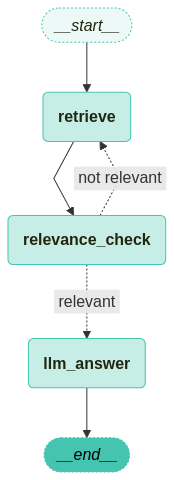

In [17]:
from utils.visualize import visualize_graph
visualize_graph(app)

## Graph Execution

### Invoking

In [35]:
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1"})

user_input = GraphState(question="RAG와 LangChain의 관계를 알려주세요.")

try:
    invoke_graph(app, user_input, config, ["retrieve", "relevance_check", "llm_answer"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>PART
RAG with LangChain</content><source>data/RAGwithLangChain.pdf</source><page>2</page></document>
<document><content>RAG를 활용한 완성도 높은 LLM 서비스 구축
With Langchain & LLamaIndex</content><source>data/RAGwithLangChain.pdf</source><page>1</page></document>
<document><content>CLIP
Introduction to LangChain</content><source>data/RAGwithLangChain.pdf</source><page>3</page></document>
<document><content>Introduction to LangChain
RAG Pipeline
User query
2024년 최저시급은 얼마야?
2024년 한국의 최저임금은 9860원입니다.
Indexing Retrieval Generation
chunks Relevant 다음 주어지는 문서를 참고해
documents chunk1: "임금은 2024년 최저
embedding documents user question에 대한 답변을
시급이며 교통비가 별도 지급된
생성하시오
다"
chunk1:
chunk2: "2024년 1월부터 최
chunk2:</content><source>data/RAGwithLangChain.pdf</source><page>4</page></document>
<document><content>Introduction to LangChain
RAG Pipeline
User query
2024년 최저시급은 얼마야?
2024년 한국의 최저임금은 9860원입니다.
Indexing Retrieval Ge

### Streaming

In [36]:
try:
    stream_graph(app, user_input, config, ["retrieve", "relevance_check", "llm_answer"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"yes"}=== [RELEVENCE CHECKING ===

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
RAG(검색 증강 생성)와 LangChain은 LLM(대형 언어 모델) 서비스를 구축하는 데 중요한 관계를 가지고 있습니다. LangChain은 RAG 파이프라인을 통해 사용자 쿼리를 처리하고, 관련 문서를 검색하여 응답을 생성하는 구조를 제공합니다.

**Source**
- data/RAGwithLangChain.pdf (page 1)
- data/RAGwithLangChain.pdf (page 4)

### Output Check

In [34]:
output = app.get_state(config).values

print(f'Question: {output["question"]}')
print("===" * 30)
print(f'Answer: {output["answer"]}')


Question: RAG와 LangChain의 관계를 알려주세요.
Answer: RAG(검색 증강 생성)와 LangChain은 LLM(대형 언어 모델) 서비스를 구축하는 데 중요한 관계를 가지고 있습니다. LangChain은 RAG 파이프라인을 통해 사용자 쿼리를 처리하고, 관련 문서를 검색하여 응답을 생성하는 구조를 제공합니다.

**Source**
- data/RAGwithLangChain.pdf (page 1)
- data/RAGwithLangChain.pdf (page 4)
